<a href="https://colab.research.google.com/github/k1-furuya/rstan001/blob/main/ARIMA%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E3%83%8F%E3%82%A4%E3%83%91%E3%83%BC%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%82%92AIC%E3%81%A8pmdarima%E3%81%A7%E6%AF%94%E8%BC%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**pmdarimaライブラリのauto_arimaを使って予測モデルを構築する。**

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import datetime

from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12,9]
plt.rcParams["font.size"] = 14

In [10]:
# データセットは、Johnson & Johnsonの四半期ごとのEPSを予測する
# https://github.com/marcopeix/TimeSeriesForecastingInPython/tree/master/CH07

dataset = "jj.csv"
df = pd.read_csv(
    dataset,
    index_col="date",
    parse_dates=True)

In [11]:
df

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61
...,...
1979-10-01,9.99
1980-01-01,16.20
1980-04-01,14.67


In [12]:
#データセットを学習データとテストデータ(直近１年間)に分割
train,test = train_test_split(df, test_size=4)

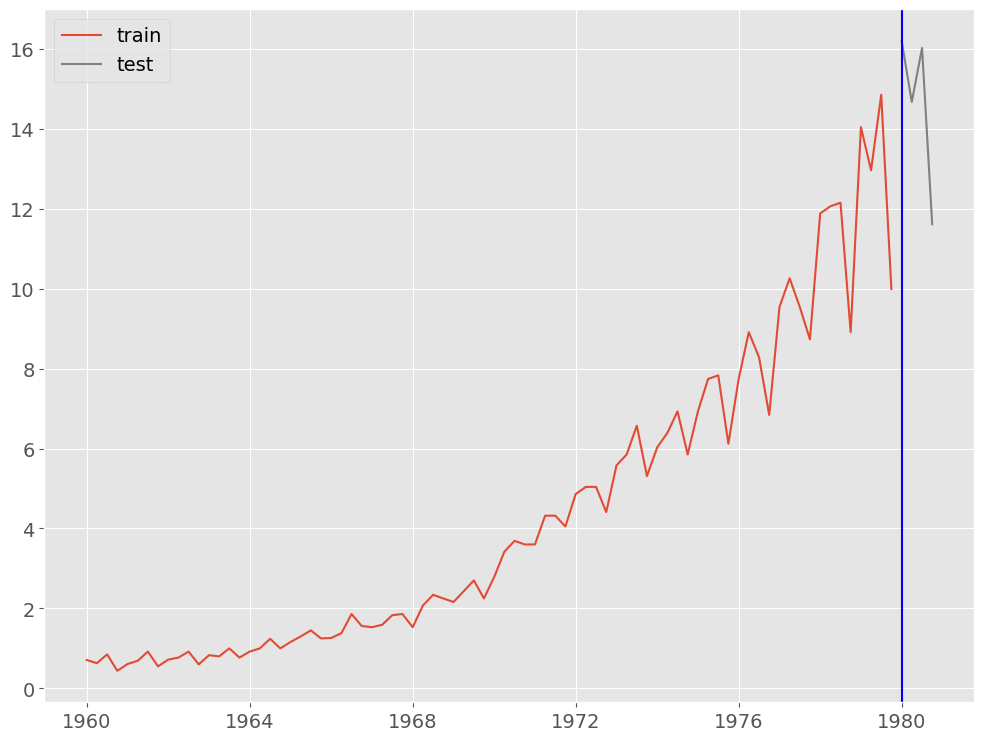

In [13]:
#グラフ（学習データとテストデータ

fig,ax = plt.subplots()

# 学習データの描写
ax.plot(
    train.index,
    train.values,
    label="train")

# テストデータの描写
ax.plot(
    test.index,
    test.values,
    label="test",
    color="gray")

# 学習データとテストデータの間の縦線の描写
ax.axvline(
    datetime.datetime(1980,1,1),
    color="blue")

# 凡例表示
ax.legend()
plt.show()

In [14]:
# 予測モデルの学習

arima_model = auto_arima(
    train,
    seasonal=True,
    m=12)

print(arima_model.summary())

# SARIMAX(0,1,2)(0,1,0)(12)が最適？

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   80
Model:             SARIMAX(0, 1, 2)x(0, 1, [], 12)   Log Likelihood                 -65.137
Date:                             Tue, 14 May 2024   AIC                            138.273
Time:                                     10:12:48   BIC                            147.092
Sample:                                          0   HQIC                           141.763
                                              - 80                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0730      0.031      2.345      0.019       0.012       0.134
ma.L1         -1.1808      

In [21]:
# 予測の実施

# 学習データ期間の予測
train_pred = arima_model.predict_in_sample()

# テストデータ期間の予測
test_pred = arima_model.predict(n_periods=4)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [22]:
# 予測精度（テストデータ）


print('RMSE:\n',
      np.sqrt(mean_squared_error(
          test.data, test_pred)))
print('MAE:\n',
      mean_absolute_error(
          test.data, test_pred))
print('MAPE:\n',
      mean_absolute_percentage_error(
          test.data, test_pred))

RMSE:
 1.473061114631087
MAE:
 1.3139710516163712
MAPE:
 0.09727417358891312


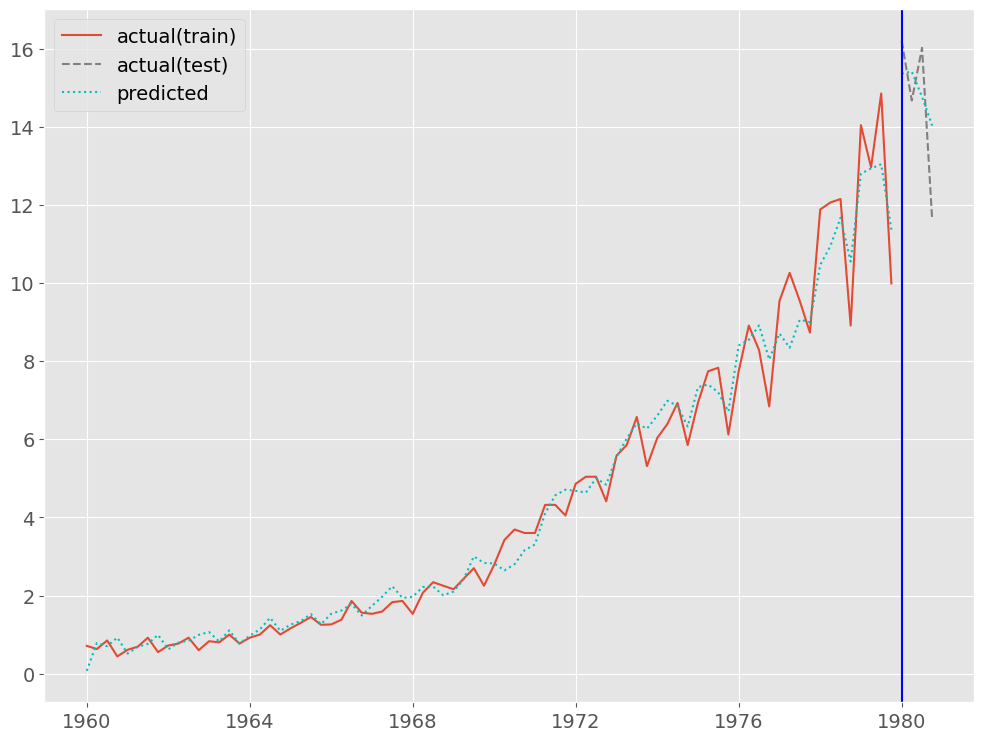

In [24]:
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値の描写
## 学習データ
ax.plot(
    train.index,
    train.data,
    linestyle='-',
    label='actual(train)')

## テストデータ
ax.plot(
    test.index,
    test.data,
    linestyle='--',
    label='actual(test)',
    color='gray')

# 予測値の描写
## 学習データ
ax.plot(
    train.index,
    train_pred,
    linestyle=':',
    color='c')

## テストデータ
ax.plot(
    test.index,
    test_pred,
    linestyle=':',
    label="predicted",
    color="c")

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    datetime.datetime(1980,1,1),
    color='blue')

# 凡例表示
ax.legend()

plt.show()

**関数を使って全ての次数をAICで比較してモデルを構築**

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [42]:
dataset = "jj.csv"
df = pd.read_csv(dataset)

In [43]:

ad_fuller_result = adfuller(df["data"])
print(f"ADF Statistic:{ad_fuller_result[0]}")
print(f"p-value:{ad_fuller_result[1]}")

ADF Statistic:2.7420165734574744
p-value:1.0


In [44]:
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305


In [45]:
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682


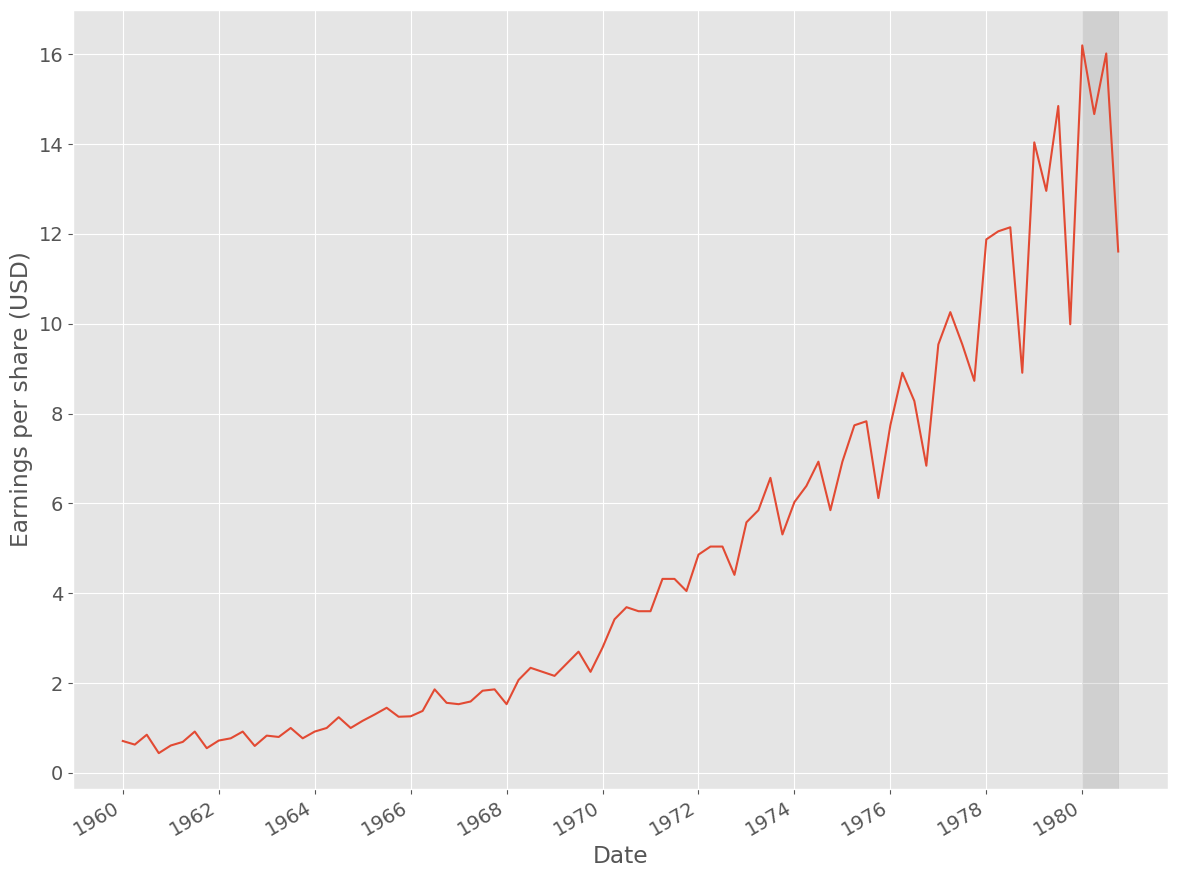

In [46]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()


In [47]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [48]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [49]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

# ARIMA(3,2,3)が最適？

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.266637
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430625
4,"(0, 3)",194.654716
5,"(0, 2)",209.274868
6,"(2, 3)",220.666965
7,"(1, 3)",228.267730
8,"(1, 2)",228.935782
9,"(2, 2)",229.974691


In [50]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.633
Date:                Tue, 14 May 2024   AIC                            115.267
Time:                        10:47:20   BIC                            131.764
Sample:                             0   HQIC                           121.871
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9994      0.037    -26.764      0.000      -1.073      -0.926
ar.L2         -0.9882      0.040    -25.002      0.000      -1.066      -0.911
ar.L3         -0.9758      0.026    -37.598      0.0

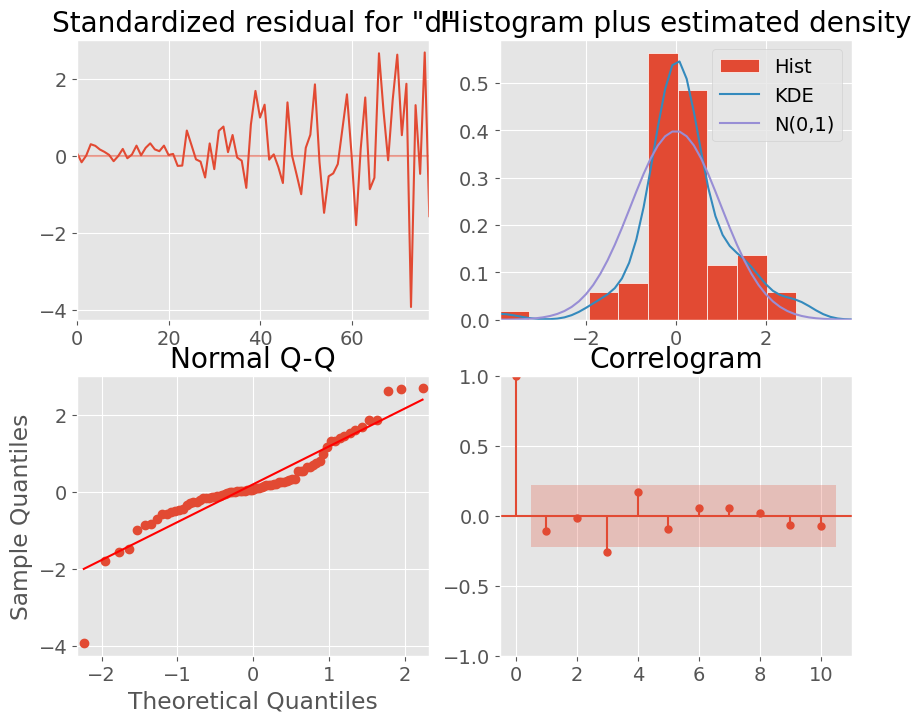

In [51]:
model_fit.plot_diagnostics(figsize=(10,8));

In [52]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [53]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [54]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.858693
81,1980-04-01,14.67,12.96,14.381508
82,1980-07-02,16.02,14.85,16.365509
83,1980-10-01,11.61,9.99,11.680906


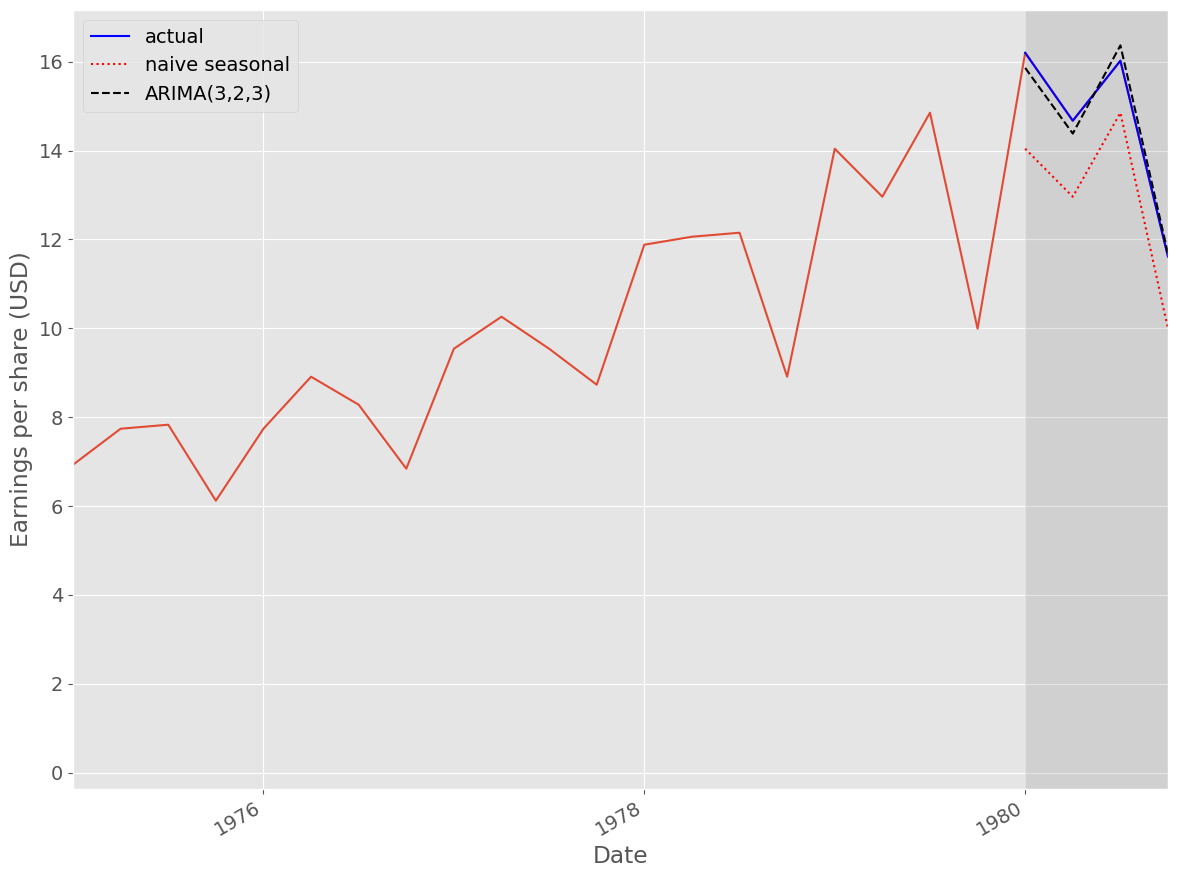

In [55]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

In [57]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7102112169997594


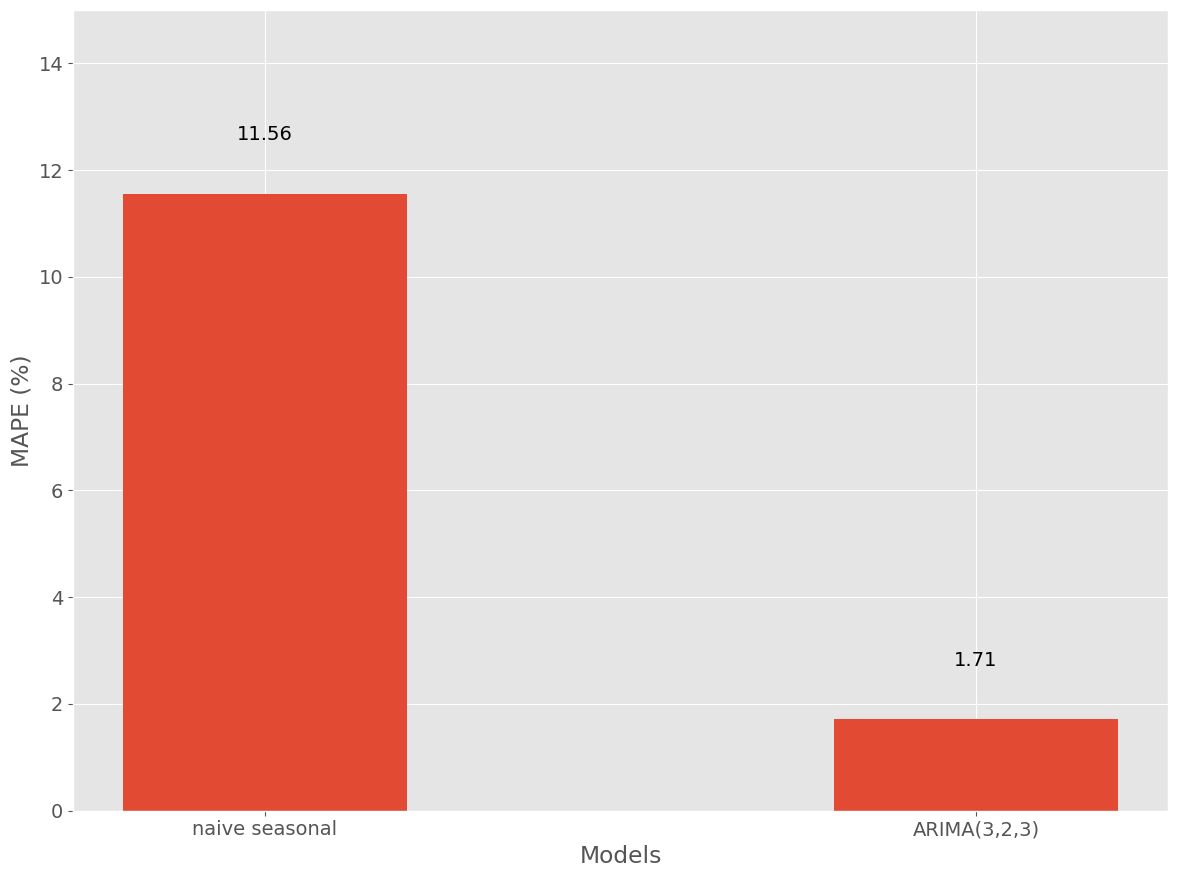

In [58]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

まとめ  
auto_arima関数 は実装が簡単で計算効率が高く、計算資源が限られている場合に有効。  
全組み合わせの探索 は計算コストが高いが、理論上、最も低いAICを持つ最適なモデルを見つけることができる。計算資源に余裕があり、非常に高い精度が求められる場合に適している。